# Data

The main data I will use in this project comes from YouTube which is my watch history data. It was sent by YouTube per my request in html format. Since I intend to use pandas and plotly for data visualasation purposes the first order of business will be to clean up the html data and convert it to csv format.

# Ads

The html file containing the data related to my watch history also included the ads I watche. Below I clean the data of those ads which there were about 9.5k ads among the 55k total videos I have watched.

In [4]:
from pathlib import Path
from bs4 import BeautifulSoup
import lxml

# Define the path to the HTML file
data_file = Path("Data") / "izleme geçmişi.html"

# Check if the file exists
if data_file.exists():
    print(f"File found: {data_file}")
else:
    print("File not found!")

# Open and parse the file
with open(data_file, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "lxml")

ads = soup.find_all(string=lambda text: text and "Google Reklamlar" in text.replace("\xa0", " ").strip())
print(f"Found {len(ads)} ads")  # Debugging: Output the number of matches

for ad in ads:
    ad_div = ad.find_parent("div", class_=lambda classes: classes and "outer-cell" in classes and "mdl-cell--12-col" in classes)
    if ad_div:
        ad_div.decompose()


# Save the cleaned chunk
cleaned_data_path = Path("Data") / "addfree_data.html"
with open(cleaned_data_path, "w", encoding="utf-8") as file:
    file.write(soup.prettify())

print(f"Cleaned HTML saved to {cleaned_data_path}")

File found: Data\izleme geçmişi.html
Found 9568 ads
Cleaned HTML saved to Data\addfree_data.html


# Community Posts

Next step of cleaning the view history data provided by YouTube is to remove the viewed community posts records as they might inflate the data regarding my usage.

In [5]:
from pathlib import Path
from bs4 import BeautifulSoup
import lxml

# Define the path to the cleaned HTML file
data_file = Path("Data") / "addfree_data.html"

# Open and parse the file
with open(data_file, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "lxml")  # Using lxml for faster parsing

# Find all strings containing "yayını görüntülendi"
posts = soup.find_all(string=lambda text: text and "yayını görüntülendi" in text)

print(f"Found {len(posts)} community post records.")  # Debugging: Output the number of matches

# Remove parent divs containing these records
for post in posts:
    post_div = post.find_parent("div", class_=lambda classes: classes and "outer-cell" in classes and "mdl-cell--12-col" in classes)
    if post_div:
        post_div.decompose()

# Save the cleaned HTML
cleaned_file_path = Path("Data") / "ncp_nadd_data.html"
with open(cleaned_file_path, "w", encoding="utf-8") as file:
    file.write(soup.prettify())

print(f"Cleaned HTML saved to {cleaned_file_path}")


Found 1252 community post records.
Cleaned HTML saved to Data\ncp_nadd_data.html


# Conversion to CSV

Now that we have a relatively clean data at hand, I converted the html file to csv to be able to utilize pandas and plotly for data visualazation.

In [5]:
from pathlib import Path
from bs4 import BeautifulSoup
import csv
import re

# Define the path to the cleaned HTML file and output CSV
data_file = Path("Data") / "ncp_nadd_data.html"
csv_file = Path("Data") / "watch_data.csv"

# Parse the HTML file
with open(data_file, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "lxml")

# Prepare to store extracted data
data = []

# Find all video entries
entries = soup.find_all("div", class_="outer-cell mdl-cell mdl-cell--12-col mdl-shadow--2dp")

for entry in entries:
    # Extract video name and video URL (from the first <a> tag)
    video_name_tag = entry.find("a", href=True)
    video_name = video_name_tag.text.strip() if video_name_tag else "Unknown"
    video_url = video_name_tag['href'].strip() if video_name_tag else "No URL"

    # Extract channel name (from the second <a> tag)
    channel_tag = entry.find_all("a", href=True)
    channel_name = channel_tag[1].text.strip() if len(channel_tag) > 1 else "Unknown"

    # Extract video watch date and hour using regex
    watch_date_match = re.search(r"(\d{1,2} \w+ \d{4})", entry.text)
    watch_hour_match = re.search(r"(\d{2}:\d{2}:\d{2})", entry.text)
    watch_date = watch_date_match.group(1) if watch_date_match else "Unknown"
    watch_hour = watch_hour_match.group(1) if watch_hour_match else "Unknown"

    # Append extracted data to the list
    data.append([video_name, video_url, channel_name, watch_date, watch_hour])

# Save extracted data to a CSV file
with open(csv_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Video Name", "Video URL", "Channel Name", "Watch Date", "Watch Hour"])
    writer.writerows(data)

print(f"Data successfully saved to {csv_file}")


Data successfully saved to Data\watch_data.csv


# Turkish Month Names Problem

Since the location of my YouTube account was set to Turkey in the data they provided me with month names were in Turkish. So in order for pandas functions to work properly I had to change them to English.

In [2]:
import pandas as pd

# Input and output file paths
input_file = "Data/watch_data.csv"
output_file = "Data/watch_data_eng.csv"

# Load the existing CSV file
df = pd.read_csv(input_file)

# Dictionary to map Turkish month names to English
month_map = {
    "Oca": "Jan", "Şub": "Feb", "Mar": "Mar", "Nis": "Apr", "May": "May", "Haz": "Jun",
    "Tem": "Jul", "Ağu": "Aug", "Eyl": "Sep", "Eki": "Oct", "Kas": "Nov", "Ara": "Dec"
}

# Replace Turkish month names with English equivalents in the 'Watch Date' column
for turkish, english in month_map.items():
    df['Watch Date'] = df['Watch Date'].str.replace(turkish, english, regex=False)

# Save the updated DataFrame to a new CSV file
df.to_csv(output_file, index=False)

print(f"New CSV file with English month names saved to: {output_file}")


New CSV file with English month names saved to: Data/watch_data_eng.csv


# Videos Watched Over Time

YouTube provided me with about 9-10 months worth of watch history data. Below visualized the daily amount of videos watched within that time period.

In [2]:
import pandas as pd
import plotly.express as px

# Load the updated CSV file
file_path = "Data/watch_data_eng.csv"
df = pd.read_csv(file_path)

# Strip spaces and clean up Watch Date column
df['Watch Date'] = df['Watch Date'].str.strip()

# Convert Watch Date to datetime format
df['Watch Date'] = pd.to_datetime(df['Watch Date'], format='%d %b %Y', errors='coerce')

# Filter the data for the desired date range
start_date = "2024-05-01"
end_date = "2024-11-25"
filtered_df = df[(df['Watch Date'] >= start_date) & (df['Watch Date'] <= end_date)]

# Group by date and count videos watched
watch_counts = filtered_df['Watch Date'].value_counts().reset_index()
watch_counts.columns = ['Watch Date', 'Videos Watched']
watch_counts = watch_counts.sort_values(by='Watch Date')

# Line chart to visualize videos watched over time
fig = px.line(watch_counts, x='Watch Date', y='Videos Watched', 
              title="Number of Videos Watched Over Time (May 2024 - Nov 2024)",
              labels={'Videos Watched': 'Videos Watched', 'Watch Date': 'Date'})

# Show the chart
fig.show()


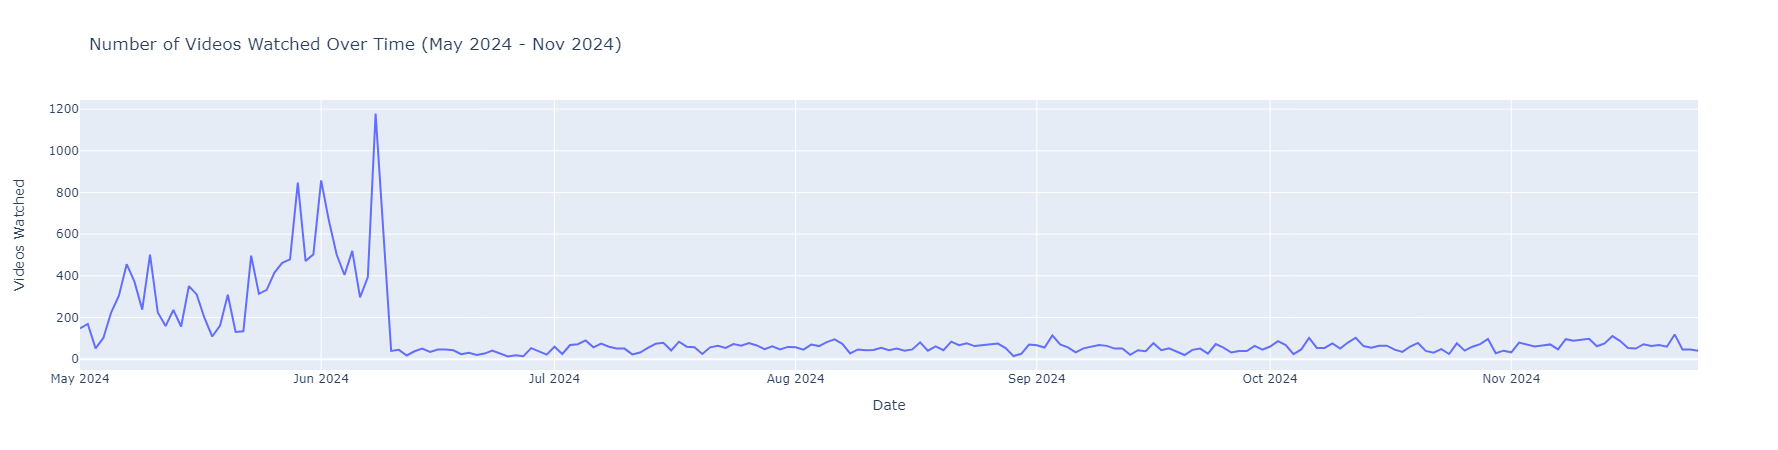

We observe here a very disportionate graph of daily video watches with a significant date being June 10th. That is the date that I stopped watchin YouTube short which is the reason why there is such a large difference in numbers before and after. This graph also proves that was a pretty good decision since we can see my video consumption was steadily increasing untill I stopped. :)

Now unfortunately YouTube does not provide any way of differentiating a shorts video from a regular one in its dataset nor any information about video duration or watch length. So I created another graph that starts from the day I stopped watching YouTube shorts.

In [3]:
import pandas as pd
import plotly.express as px

# Load the updated CSV file
file_path = "Data/watch_data_eng.csv"
df = pd.read_csv(file_path)

# Strip spaces and clean up Watch Date column
df['Watch Date'] = df['Watch Date'].str.strip()

# Convert Watch Date to datetime format
df['Watch Date'] = pd.to_datetime(df['Watch Date'], format='%d %b %Y', errors='coerce')

# Filter the data starting from June 10th, 2024
start_date = "2024-06-10"
filtered_df = df[df['Watch Date'] >= start_date]

# Group by date and count videos watched
watch_counts = filtered_df['Watch Date'].value_counts().reset_index()
watch_counts.columns = ['Watch Date', 'Videos Watched']
watch_counts = watch_counts.sort_values(by='Watch Date')

# Line chart to visualize videos watched over time
fig = px.line(watch_counts, x='Watch Date', y='Videos Watched', 
              title="Number of Videos Watched Over Time (Starting June 10th, 2024)",
              labels={'Videos Watched': 'Videos Watched', 'Watch Date': 'Date'})

# Show the chart
fig.show()


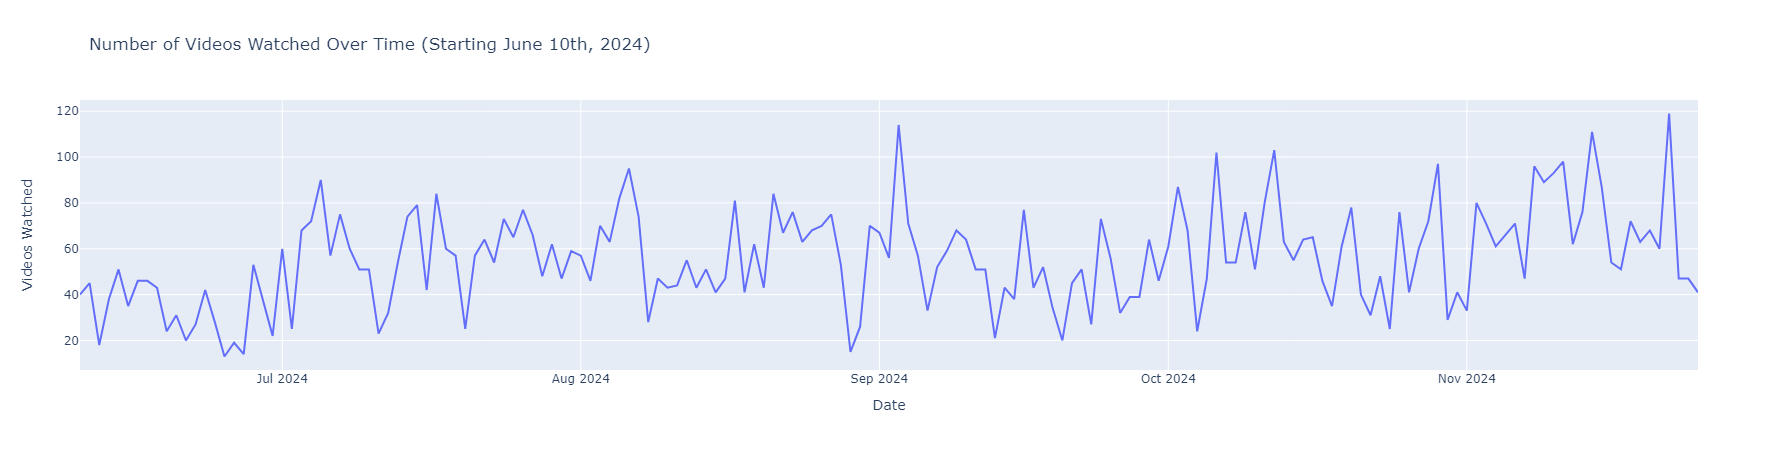

Lastly since the graph we ended up with seemed very volatile and hard to read I decided to recrate it as a scatter plot with a regression trend line to get a better overall estimation. This showed that there was a small increase in my daily video consumption overtime.

In [1]:
import pandas as pd
import plotly.express as px

# Load the updated CSV file
file_path = "Data/watch_data_eng.csv"
df = pd.read_csv(file_path)

# Clean Watch Date column
df['Watch Date'] = df['Watch Date'].str.strip()
df['Watch Date'] = pd.to_datetime(df['Watch Date'], format='%d %b %Y', errors='coerce')

# Filter data starting from June 10th, 2024
start_date = "2024-06-10"
filtered_df = df[df['Watch Date'] >= start_date]

# Group by date and count videos watched
watch_counts = filtered_df['Watch Date'].value_counts().reset_index()
watch_counts.columns = ['Watch Date', 'Videos Watched']
watch_counts = watch_counts.sort_values(by='Watch Date')

# Regression trendline chart
fig = px.scatter(watch_counts, x='Watch Date', y='Videos Watched', 
                 title="Number of Videos Watched Over Time (With Regression Trend Line)",
                 labels={'Videos Watched': 'Videos Watched', 'Watch Date': 'Date'},
                 trendline="ols",  # Add regression line
                 trendline_color_override="red")  # Make trend line red for clarity

# Show the chart
fig.show()


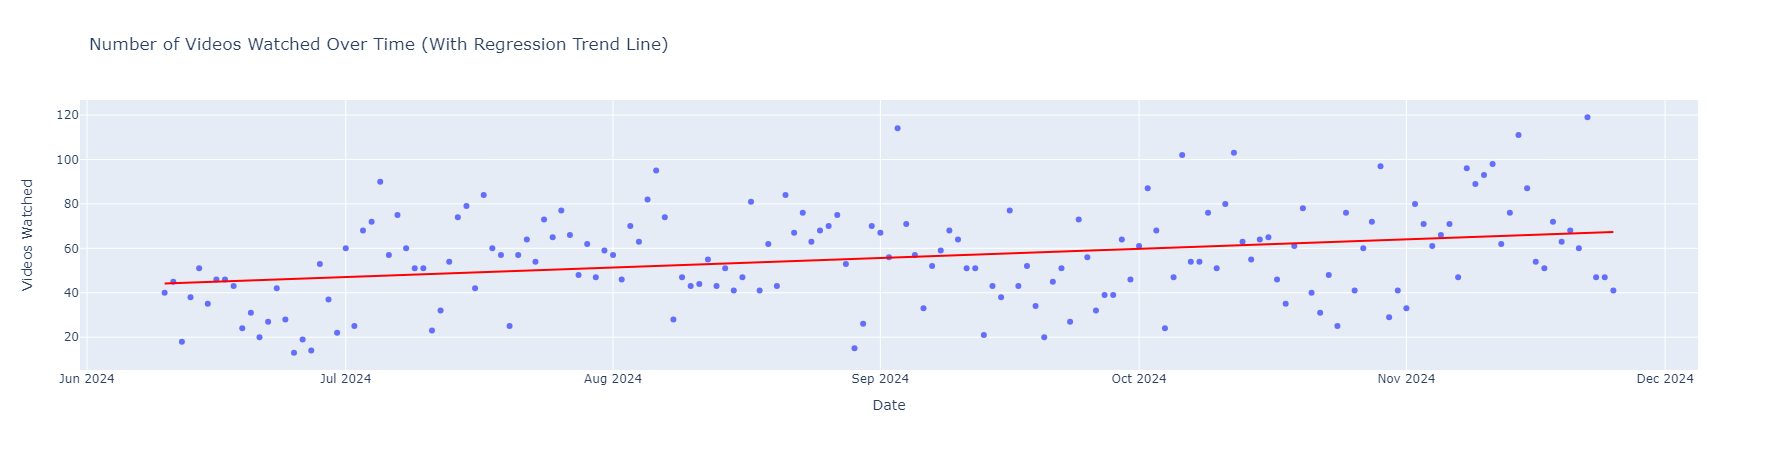